Número de palavras: 6964
Número de tags: 6
Número de inputs: 84
O maior input tem 1682 palavras


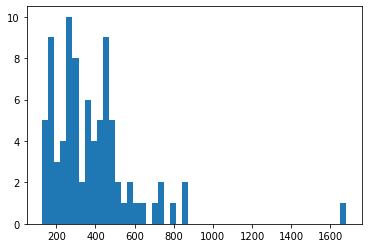

In [32]:
# --------------------------------------------------------------
# Load data file to train model
# --------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import array as arr

data = pd.read_csv("export_dataframe_84CVs_SKILL_HF_V2.csv", encoding="latin1")
data = data.fillna(method="ffill")

# Nº de palavras
words = set(list(data['Word'].values))
words.add('PADword')
print("Número de palavras: {}".format(len(words)))

# Nº de tags
tags = list(set(data["Tag"].values))
n_tags = len(tags)
print("Número de tags: {}".format(len(tags)))

class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(data)
sent = getter.get_next()

# Nº de inputs
sentences = getter.sentences
print("Número de inputs: {}".format(len(sentences)))

# Maior numero de palavras num input
largest_sen = max(len(sen) for sen in sentences)
print('O maior input tem {} palavras'.format(largest_sen))

# Distribuição da quantidade da palavras por input
%matplotlib inline
plt.hist([len(sen) for sen in sentences], bins= 50)
plt.show()

# Atribuição de um valor numérico a cada uma das palavras do vocabulário existente (Inputs e Tags)
words2index = {w:i for i,w in enumerate(words)}
tags2index = {t:i for i,t in enumerate(tags)}

In [33]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# Split dos inputs por palavra. Consoante o tamanho máximo dos inputs é acrescentada a palavra PADword para todos os inputs terem a mesma dimensão.
# Variável new_X fica com as entradas separadas por palavra e já com padding
# -------------------------------------------------------------------------------------------------------------------------------------------------

largest_word = max(len(word) for word in words2index)
max_len = largest_sen
X = [[w[0]for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X.append(new_seq)

# Outputs passam para valores numéricos
from keras.preprocessing.sequence import pad_sequences
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])

# Separação de 2 inputs para testar o modelo depois de treinado
aux = len(new_X) - 2

X_tr, X_te = new_X[:aux], new_X[aux:]
y_tr, y_te = y[:aux], y[aux:]

print(len(new_X))
print(len(y))
print(len(X_tr))
print(len(y_tr))
print(len(X_te))
print(len(y_te))

84
84
82
82
2
2


In [34]:
# ------------------------------------------------------------------------------
# Definição do modelo. Para ver o modelo descomentar linha com #model.summary()
# ------------------------------------------------------------------------------

batch_size = 2
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
sess = tf.Session()
K.set_session(sess)

elmo_model = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

# Modelo
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

model = Model(input_text, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
#model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [35]:
# -------------------------------------------------------------------------------
# Separação do conjunto de treino em dados de treino e dados de validação
# Separação dos inputs em conjunto de treino (80%) e conjunto de validação (20%)
# -------------------------------------------------------------------------------

val_per = 0.2

x = int((1-val_per) * len(X_tr))

if (x % 2) != 0: x -= 1

X_tr2, X_val2 = X_tr[:x], X_tr[x:]
y_tr2, y_val2 = y_tr[:x], y_tr[x:]
y_tr2 = y_tr2.reshape(y_tr2.shape[0], y_tr2.shape[1], 1)
y_val2 = y_val2.reshape(y_val2.shape[0], y_val2.shape[1], 1)

print(len(X_tr))
print(len(y_tr))

print(len(X_tr2))
print(len(y_tr2))
print(len(X_val2))
print(len(y_val2))

82
82
64
64
18
18


In [36]:
# -----------------
# Treinar o modelo
# -----------------

history = model.fit(np.array(X_tr2), y_tr2, validation_data=(np.array(X_val2), y_val2), batch_size=batch_size, epochs=2, verbose=1)

Train on 64 samples, validate on 18 samples
Epoch 1/2
64/64 [==============================] - 437s 7s/step - loss: 0.1280 - accuracy: 0.9607 - val_loss: 0.0242 - val_accuracy: 0.9951
Epoch 2/2
64/64 [==============================] - 433s 7s/step - loss: 0.0359 - accuracy: 0.9924 - val_loss: 0.0196 - val_accuracy: 0.9961


In [37]:
# --------------------------------------------------------------------------
# Previsão com dados de teste, obtenção da precisão e dos resultados finais
# --------------------------------------------------------------------------

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
test_pred = model.predict(np.array(X_te), batch_size=batch_size, verbose=1)

idx2tag = {i: w for w, i in tags2index.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te)

# Precisão
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
print("\n")
print(classification_report(test_labels, pred_labels))

# Resultados
file1 = open("myfiletest.txt","a")#append mode
largest_word = largest_word + 1
print("Palavra" + " "*(largest_word-7) + "Prev - Real")
print("="*(largest_word+14))
file1.write("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)) + "\n")
file1.write(classification_report(test_labels, pred_labels) + "\n")
file1.write("Palavra" + " "*(largest_word-7) + "Prev ---- Real" + "\n")
file1.write("="*(largest_word+14) + "\n")
space = " "
i=0
for pred in pred_labels:
    j=0
    for pred2 in pred:
        if X_te[i][j] == "PADword": 
            break
        print(X_te[i][j] + " "*(largest_word-len(X_te[i][j])) + pred2 + " "*(10-len(pred2)) + test_labels[i][j])
        file1.write(X_te[i][j] + " "*(largest_word-len(X_te[i][j])) + pred2 + " "*(10-len(pred2)) + test_labels[i][j] + "\n")
        j=j+1
    i=i+1
file1.close()

     O         O
Europeu                                                                    O         O
Comum                                                                      O         O
de                                                                         O         O
Referência                                                                 O         O
para                                                                       O         O
as                                                                         O         O
Línguas                                                                    O         O
União                                                                      O         O
Europeia                                                                   O         O
2002-2013                                                                  O         O
http                                                                       O         O
//europass                

In [38]:
# -------------------------------
# Gravar o modelo em formato .pb
# -------------------------------

#export_path = 'so-test/'

#with tf.keras.backend.get_session() as sess:
#    tf.saved_model.simple_save(sess, export_path, inputs={'input_image': model.input}, outputs={t.name: t for t in model.outputs})